Wczytanie rastra wielokanałowego CIR:

In [477]:
from osgeo import gdal
gdal.UseExceptions()
from typing import Union
from pathlib import Path
import numpy as np

def read_spatial_raster(path: Union[str, Path]) -> gdal.Dataset:
    dataset = gdal.Open(str(path))
    assert dataset is not None, "Read spatial raster returned None"
    return dataset

raster_file_CIR = "CIR2015.tif"
raster_file_RGB = "RGB2015.tif"
raster_file_CIR_2023 = "CIR2023.tif"    
raster_file_RGB_2023 = "RGB2023.tif"

raster_dataset_CIR = read_spatial_raster(raster_file_CIR)
raster_dataset_RGB = read_spatial_raster(raster_file_RGB)
raster_dataset_CIR_2023 = read_spatial_raster(raster_file_CIR_2023)
raster_dataset_RGB_2023 = read_spatial_raster(raster_file_RGB_2023)

c:\Users\mplaciszewska\anaconda3\envs\teledetekcja2\Lib\site-packages\osgeo\gdal.py:8817: RuntimeWarning: CIR2015.tif: JPEGFixupTagsSubsamplingSec:Auto-corrected former TIFF subsampling values [2,2] to match subsampling values inside JPEG compressed data [1,1]
  return _gdal.Open(*args)
c:\Users\mplaciszewska\anaconda3\envs\teledetekcja2\Lib\site-packages\osgeo\gdal.py:8817: RuntimeWarning: RGB2015.tif: JPEGFixupTagsSubsamplingSec:Auto-corrected former TIFF subsampling values [2,2] to match subsampling values inside JPEG compressed data [1,1]
  return _gdal.Open(*args)


Wizualizacja kanałów rastra w matplotlib:

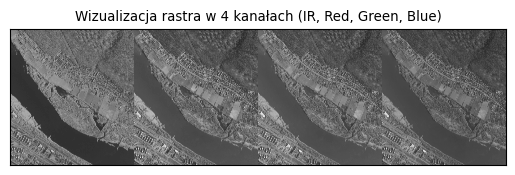

In [478]:
import matplotlib.pyplot as plt

def read_raster_band(dataset: gdal.Dataset, band_number: int) -> gdal.Band:
    assert 0 < band_number <= dataset.RasterCount, f"Band number {band_number} is invalid for raster with {dataset.RasterCount} bands."
    band = dataset.GetRasterBand(band_number)
    assert band is not None, f"Unable to read band {band_number}"
    return band

def read_band_as_array(band: gdal.Band) -> np.ndarray:
    array = band.ReadAsArray()
    array = np.copy(array)  # To make sure we do not get memory errors
    return array

nir_band = read_raster_band(raster_dataset_CIR, 1)
nir_array = read_band_as_array(nir_band)

red_band = read_raster_band(raster_dataset_CIR, 2)
red_array = read_band_as_array(red_band)

green_band = read_raster_band(raster_dataset_CIR, 3)
green_array = read_band_as_array(green_band)

blue_band = read_raster_band(raster_dataset_RGB, 3)
blue_array = read_band_as_array(blue_band)

#wizualizacja 4 kanalow na calym rastrze
rgb_h = np.hstack((nir_array, red_array, green_array, blue_array))
plt.imshow(rgb_h, cmap='gray')
plt.title("Wizualizacja rastra w 4 kanałach (IR, Red, Green, Blue)")
plt.xticks([])
plt.yticks([])
plt.show()


Wczytanie danych wektorowych (dróg), transformacja z układu natywnego do układu pikselowego

In [479]:
from typing import Tuple, List
import geopandas as gpd
import pandas as pd
import shapely

# raster_dataset = np.dstack((nir, red, green, blue))

def points_to_pixels(points: np.ndarray, geotransform: List[float]) -> np.ndarray:
    c, a, _, f, _, e = geotransform
    columns = (points[:, 0] - c) / a
    rows = (points[:, 1] - f) / e
    pixels = np.vstack([rows, columns])
    pixels = pixels.T
    return pixels

def read_features_to_geopandas(path: Union[str, Path]) -> gpd.GeoDataFrame:
    features = gpd.read_file(path)
    return features

def reproject_geodataframe(features: gpd.GeoDataFrame, crs: str) -> gpd.GeoDataFrame:
    return features.to_crs(crs)

def convert_to_pixel_system(features: gpd.GeoDataFrame, geotransform: List[float]) -> gpd.GeoDataFrame:
    def transform_function(xy: np.ndarray):
        ij = points_to_pixels(xy, geotransform)
        ji = ij[:, [1, 0]]
        return ji
    
    indices = features.index
    for i in indices:
        geometry = features.loc[i, "geometry"]
        geometry = shapely.transform(geometry, transform_function)  # To make our solution work for every type of geometry
        features.loc[i, "geometry"] = geometry
    return features
    
features_file = "drogi.shp"
features = read_features_to_geopandas(features_file)
features = reproject_geodataframe(features, raster_dataset_CIR.GetProjection())
features = convert_to_pixel_system(features, raster_dataset_CIR.GetGeoTransform())
print("OK")


OK


Wycięcie mniejszego fragmentu rastra w obrębie kilku wybranych poligonów:

In [480]:
chosen_features= []
chosen_polygons = []

bounds_list = []
nir_fragments = []
red_fragments = []
green_fragments = []
blue_fragments = []

chosen_features.append(features.iloc[1])
chosen_features.append(features.iloc[2])
chosen_features.append(features.iloc[9])
chosen_features.append(features.iloc[8])

def clip_to_feature(example_polygon):
    bounds = example_polygon.bounds
    bounds = np.float64(bounds)
    print("BBOX poligonu:", bounds)

    bounds[:2] = np.floor(bounds[:2])
    bounds[2:] = np.ceil(bounds[2:])
    bounds = np.int64(bounds)
    print("BBOX poligonu (integer):", bounds)
    return bounds

def clip_array(bounds, array):
    fragment = array[
        bounds[1]: bounds[3],
        bounds[0]: bounds[2]
    ]
    return fragment

for i in range(len(chosen_features)):
    chosen_polygons.append(chosen_features[i]["geometry"])
    bounds = clip_to_feature(chosen_polygons[i])
    bounds_list.append(bounds)
    nir_fragments.append(clip_array(bounds, nir_array))
    red_fragments.append(clip_array(bounds, red_array))
    green_fragments.append(clip_array(bounds, green_array))
    blue_fragments.append(clip_array(bounds, blue_array))


BBOX poligonu: [4729.9656 2709.8456 4810.214  2881.9988]
BBOX poligonu (integer): [4729 2709 4811 2882]
BBOX poligonu: [4673.5984 2874.9072 4903.9708 3052.3   ]
BBOX poligonu (integer): [4673 2874 4904 3053]
BBOX poligonu: [4512.1656 2409.8816 4685.6228 2610.0748]
BBOX poligonu (integer): [4512 2409 4686 2611]
BBOX poligonu: [4843.456  3046.4572 4952.982  3307.8172]
BBOX poligonu (integer): [4843 3046 4953 3308]


Maskowanie pikseli położonych w obrębie wyciętego fragmentu rastra (BBOX), ale poza wybranym poligonem i wizualizacja wybranych poligonów w każdym z kanałów spektralnych.

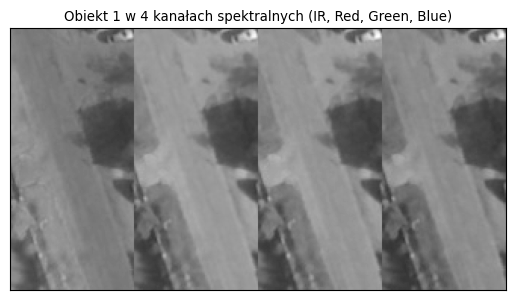

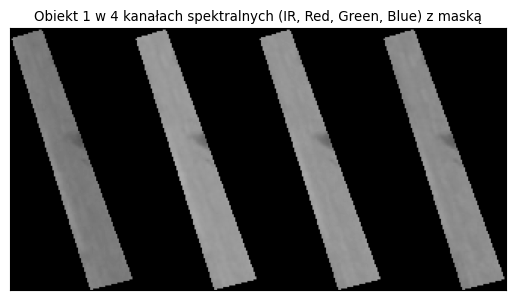

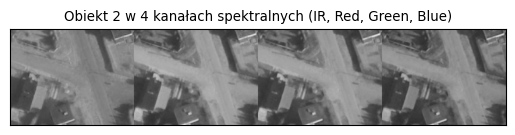

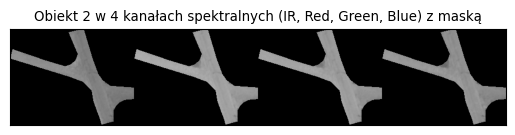

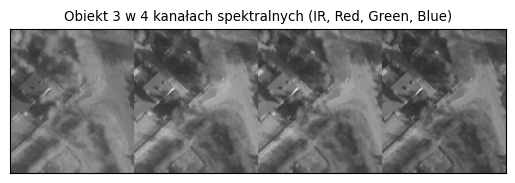

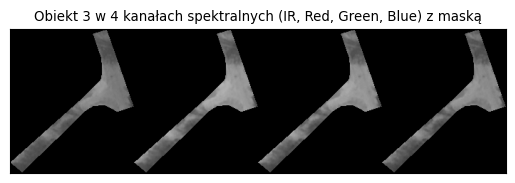

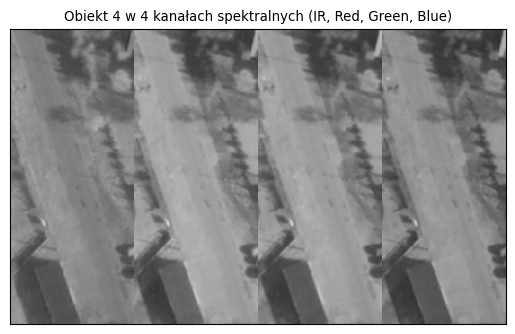

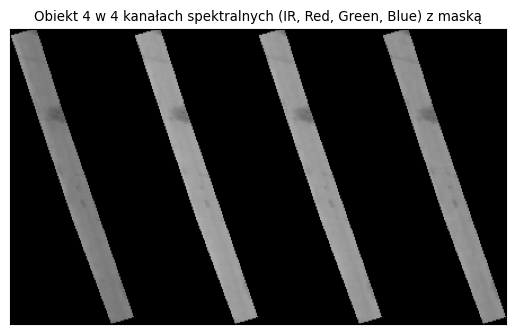

In [481]:
from rasterio.features import rasterize

def plot_object_in_channels(nir, red, green, blue):
    channels_stack = np.hstack((nir, red, green, blue))
    plt.imshow(channels_stack, cmap='gray', vmin=0, vmax=255)
    plt.rcParams.update({'font.size': 8})
    plt.xticks([])
    plt.yticks([])
   
# no_data_masks = []
nir_masked_list = []
red_masked_list = []
green_masked_list = []
blue_masked_list = []


def mask_fragment(fragment, polygon_in_fragment_frame):
    no_data_mask = rasterize([polygon_in_fragment_frame], fragment.shape)
    no_data_mask = np.bool_(no_data_mask)
    no_data_mask = ~no_data_mask    # Rasterio puts True inside polygon
    masked_fragment = np.copy(fragment)
    masked_fragment[no_data_mask] = 0
    return masked_fragment, no_data_mask

for i in range(len(chosen_polygons)):
    polygon_in_fragment_frame = shapely.affinity.translate(chosen_polygons[i], -bounds_list[i][0], -bounds_list[i][1])
    nir_masked, nir_no_data_mask = mask_fragment(nir_fragments[i], polygon_in_fragment_frame)
    red_masked, red_no_data_masked = mask_fragment(red_fragments[i], polygon_in_fragment_frame)
    green_masked, green_no_data_masked = mask_fragment(green_fragments[i], polygon_in_fragment_frame)
    blue_masked, blue_no_data_masked = mask_fragment(blue_fragments[i], polygon_in_fragment_frame)
    nir_masked_list.append((nir_masked, nir_no_data_mask))
    red_masked_list.append((red_masked, red_no_data_masked))
    green_masked_list.append((green_masked, green_no_data_masked))
    blue_masked_list.append((blue_masked, blue_no_data_masked))
    plot_object_in_channels(nir_fragments[i], red_fragments[i], green_fragments[i], blue_fragments[i])
    plt.title(f"Obiekt {i + 1} w 4 kanałach spektralnych (IR, Red, Green, Blue)")
    plt.show()
    plot_object_in_channels(nir_masked, red_masked, green_masked, blue_masked)
    plt.title(f"Obiekt {i + 1} w 4 kanałach spektralnych (IR, Red, Green, Blue) z maską")
    plt.show()
    

Zestawienie wybranych statystyk numerycznych w poszczególnych kanałach obrazu

[[ 88.         121.         123.         126.         146.
  124.17280842]
 [ 90.         125.         129.         139.         157.
  131.09847738]
 [ 68.          91.         114.         123.         162.
  109.52020202]
 [ 87.         124.         127.         130.         154.
  127.51747224]]


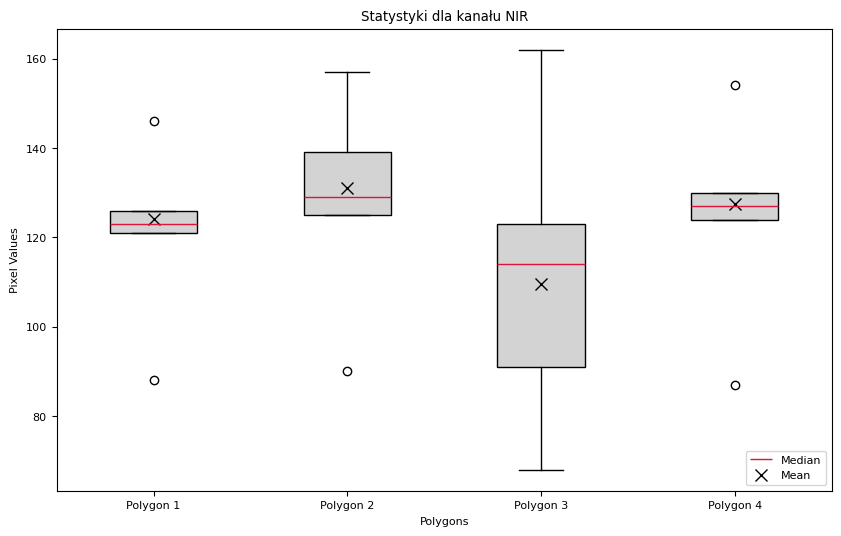

[[108.         152.         154.         156.         172.
  153.44495308]
 [102.         155.         160.         166.         178.
  159.49983569]
 [ 65.         103.         136.         152.         180.
  128.56660354]
 [111.         156.         159.         162.         178.
  158.41329197]]


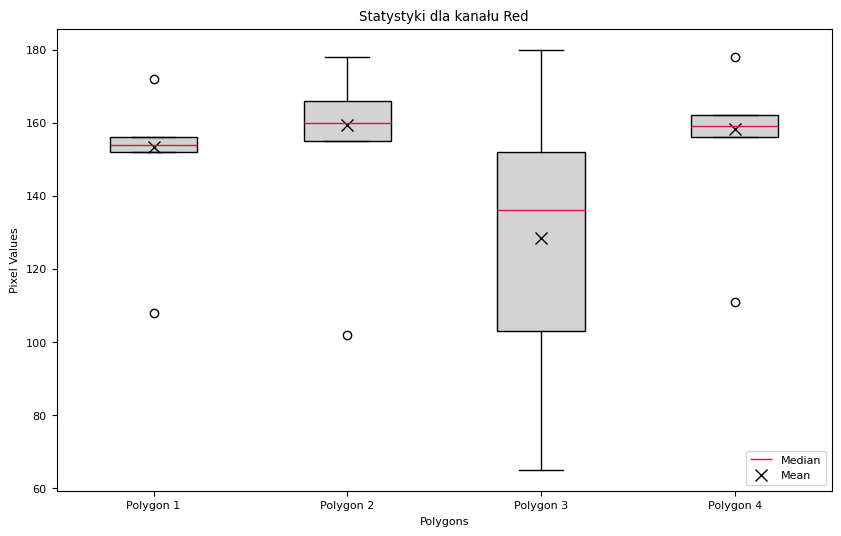

[[102.         147.         149.         151.         167.
  148.8049897 ]
 [ 98.         150.         155.         161.         175.
  154.53423157]
 [ 65.         100.         130.         146.         176.
  123.68623737]
 [104.         152.         155.         158.         172.
  153.93043762]]


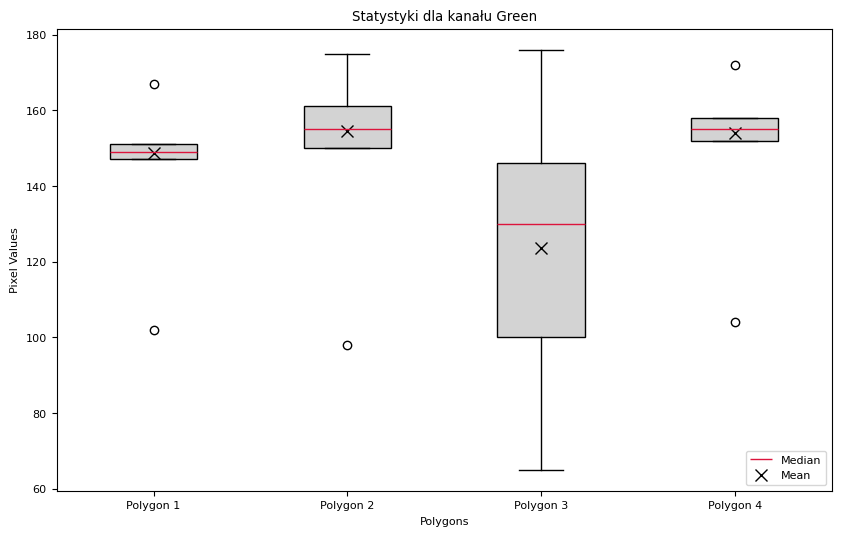

[[ 98.         137.         139.         142.         156.
  139.20553902]
 [ 87.         140.         145.         149.         164.
  143.8603352 ]
 [ 60.          93.         120.         136.         163.
  114.98279672]
 [ 97.         142.         145.         148.         161.
  144.10744611]]


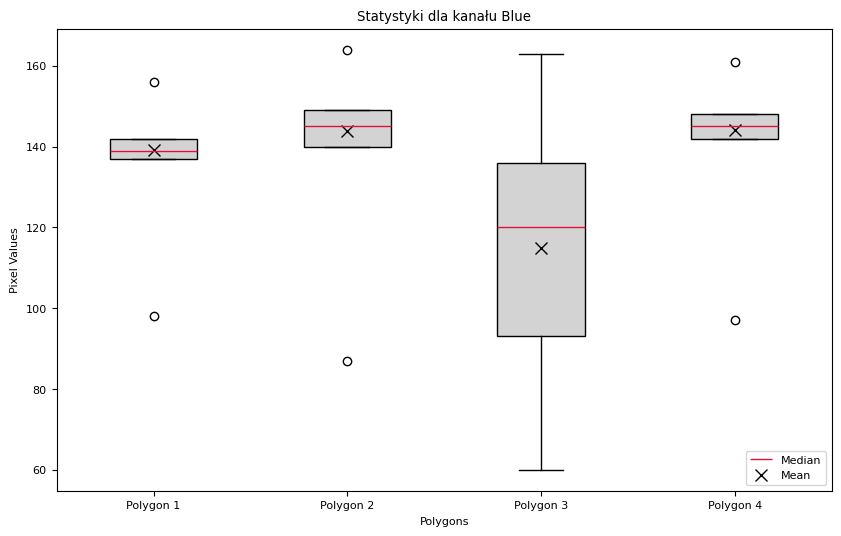

In [540]:
nir_statistics = []
red_statistics = []
green_statistics = []
blue_statistics = []

def calc_statistics(fragment, no_data_mask=None):
    if no_data_mask is None:
        no_data_mask = fragment == 0
    pixel_values = fragment[~no_data_mask] # Select just valid pixels
    # calculate quartiles
    q1 = np.percentile(pixel_values, 25)
    median = np.percentile(pixel_values, 50)
    q3 = np.percentile(pixel_values, 75)
    return  pixel_values.min(), q1, median, q3, pixel_values.max(), pixel_values.mean()

for i in range(len(chosen_polygons)):
    nir_statistics.append(calc_statistics(nir_masked_list[i][0], nir_masked_list[i][1]))
    red_statistics.append(calc_statistics(red_masked_list[i][0], red_masked_list[i][1]))
    green_statistics.append(calc_statistics(green_masked_list[i][0], green_masked_list[i][1]))
    blue_statistics.append(calc_statistics(blue_masked_list[i][0], blue_masked_list[i][1]))

nir_statistics = np.array(nir_statistics)
print(nir_statistics)
red_statistics = np.array(red_statistics)

green_statistics = np.array(green_statistics)
blue_statistics = np.array(blue_statistics)

def plot_boxplot(statistics, channel_name):
    """
    Plots a boxplot where each box represents the statistics (min, max, mean, std) for a specific polygon.

    Parameters:
        statistics (ndarray): Array of shape (num_polygons, 4), where each row contains [min, max, mean, std] for a polygon.
        channel_name (str): Name of the channel (e.g., 'NIR', 'Red', etc.)
    """
    fig, ax = plt.subplots(figsize=(10, 6))
    statistics_plot = statistics [:, :5]
    
    # transpose the data to group by polygon
    data_by_polygon = statistics_plot.T
    data_by_polygon_mean = statistics.T

    # create a boxplot for each polygon's statistics
    boxplot = ax.boxplot(data_by_polygon, tick_labels=[f'Polygon {i+1}' for i in range(statistics_plot.shape[0])], patch_artist=True, boxprops=dict(facecolor='lightgray'), medianprops=dict(color='crimson'))
    #display mean as a cross:
    for i, mean in enumerate(data_by_polygon_mean[5]):
        ax.plot(i+1, mean, 'x', markersize=8, markeredgewidth=1, color = 'black')

    ax.legend([boxplot["medians"][0], ax.plot([], [], 'x', markersize=8, markeredgewidth=1, color='black')[0]], ['Median', 'Mean'], loc='lower right')

    ax.set_ylabel('Pixel Values')
    ax.set_xlabel('Polygons')

plot_boxplot(nir_statistics, 'NIR')
plt.title("Box plot dla kanału NIR")
plt.show()
print(red_statistics)
plot_boxplot(red_statistics, 'Red')
plt.title("Box plot dla kanału Red")
plt.show()
print(green_statistics)
plot_boxplot(green_statistics, 'Green')
plt.title("Box plot dla kanału Green")
plt.show()
print(blue_statistics)
plot_boxplot(blue_statistics, 'Blue')
plt.title("Box plot dla kanału Blue")
plt.show()

Porównanie wyglądu obiektów na wybranych kompozycjach barwnych.

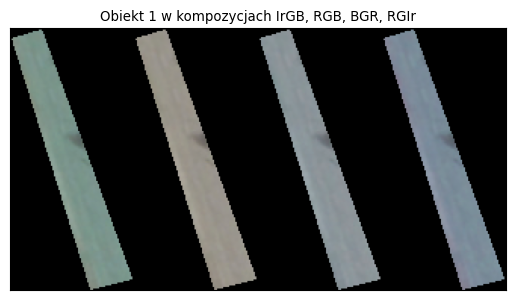

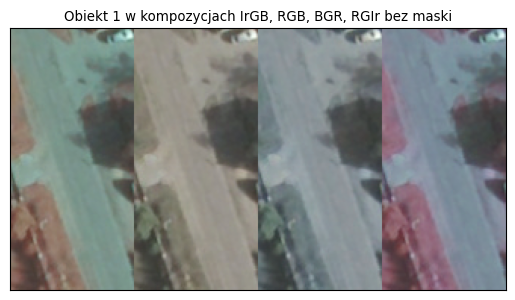

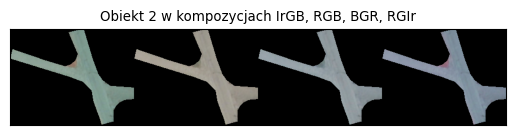

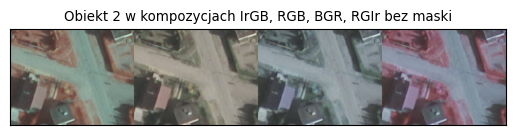

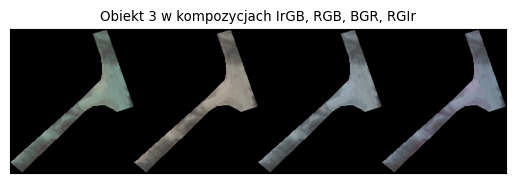

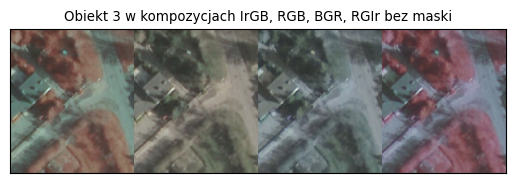

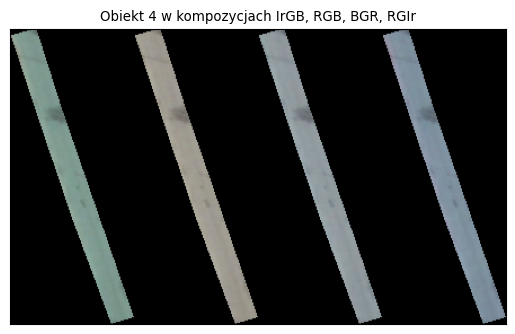

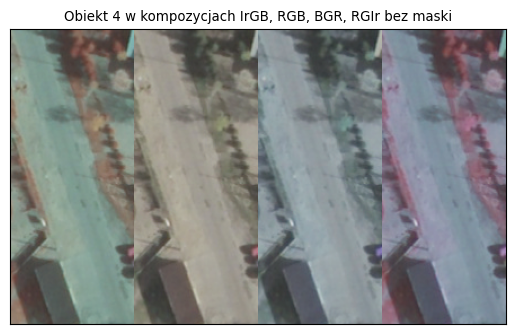

In [541]:
def plot_object_in_composition(channel1, channel2, channel3):
    composition = np.dstack((channel1, channel2, channel3))
    plt.imshow(composition)
    plt.xticks([])
    plt.yticks([])
    return composition

for i in range(len(chosen_polygons)):
    composition1 = plot_object_in_composition(nir_masked_list[i][0], green_masked_list[i][0], blue_masked_list[i][0])
    composition2 = plot_object_in_composition(red_masked_list[i][0], green_masked_list[i][0], blue_masked_list[i][0])
    composition3 = plot_object_in_composition(blue_masked_list[i][0], green_masked_list[i][0], red_masked_list[i][0])
    composition4 = plot_object_in_composition(nir_masked_list[i][0], blue_masked_list[i][0], red_masked_list[i][0])
    composition_hstack = np.hstack((composition1, composition2, composition3, composition4))
    plt.imshow(composition_hstack)
    plt.title(f"Obiekt {i + 1} w kompozycjach IrGB, RGB, BGR, RGIr")
    plt.savefig(f"object_{i + 1}_compositions.png")
    plt.show()
    composition1_unmasked = plot_object_in_composition(nir_fragments[i], green_fragments[i], blue_fragments[i])
    composition2_unmasked = plot_object_in_composition(red_fragments[i], green_fragments[i], blue_fragments[i])
    composition3_unmasked = plot_object_in_composition(blue_fragments[i], green_fragments[i], red_fragments[i])
    composition4_unmasked = plot_object_in_composition(nir_fragments[i], blue_fragments[i], red_fragments[i])
    composition_hstack_unmasked = np.hstack((composition1_unmasked, composition2_unmasked, composition3_unmasked, composition4_unmasked))
    plt.imshow(composition_hstack_unmasked)
    plt.title(f"Obiekt {i + 1} w kompozycjach IrGB, RGB, BGR, RGIr bez maski")
    plt.show()


Wyznaczenie wskaźnika NDVI - Normalized Difference Vegetation Index i TNDVI - Transformed Normalized Difference Vegetation Index

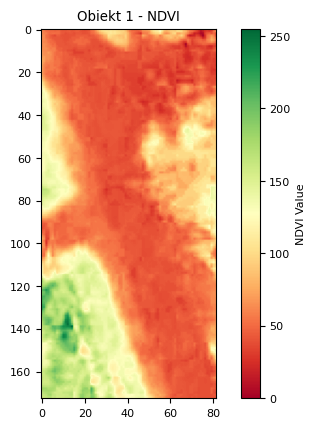

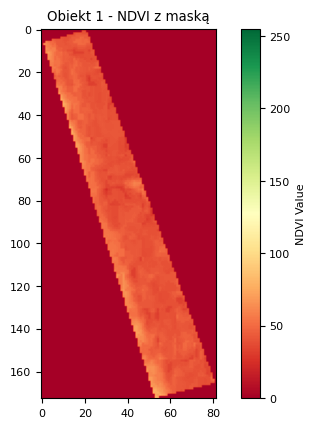

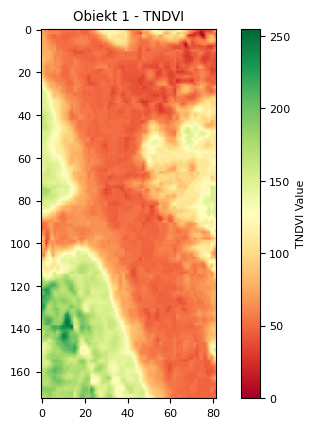

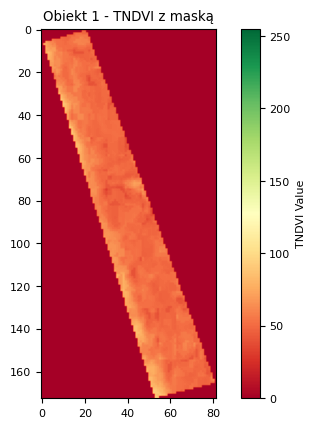

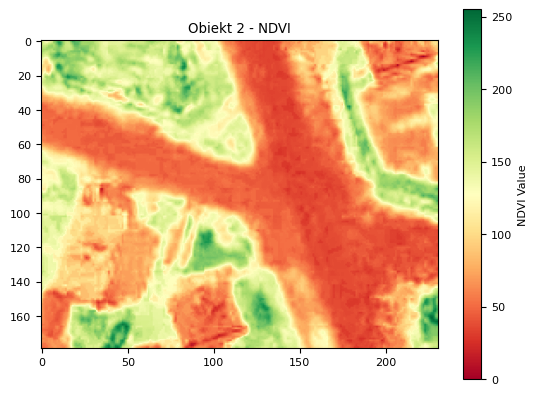

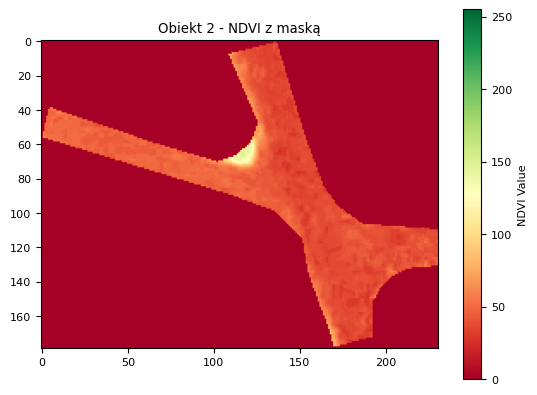

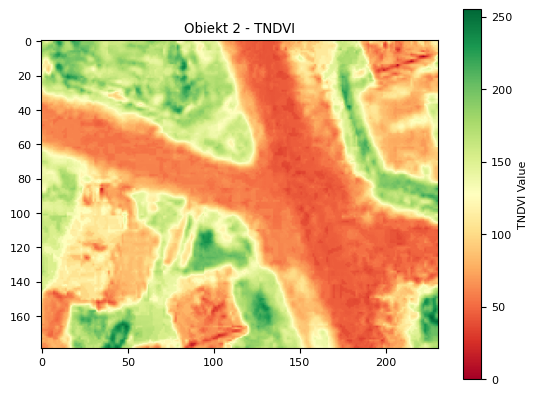

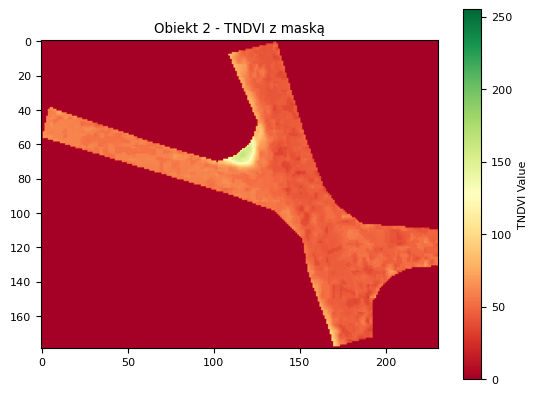

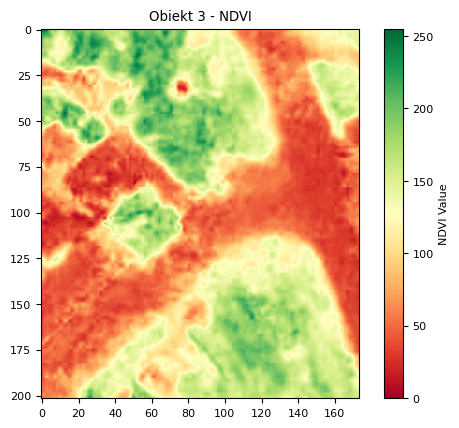

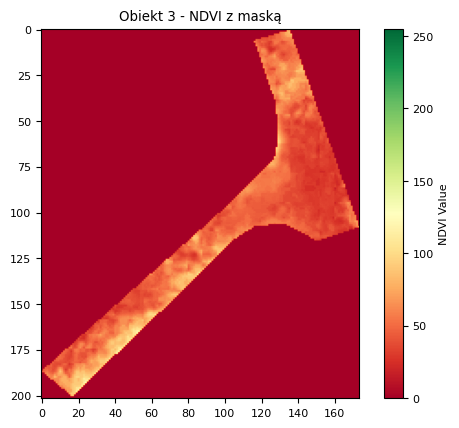

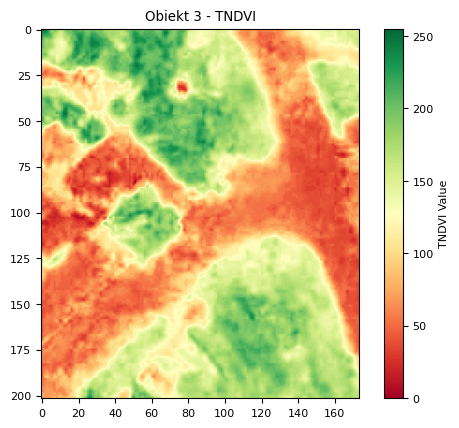

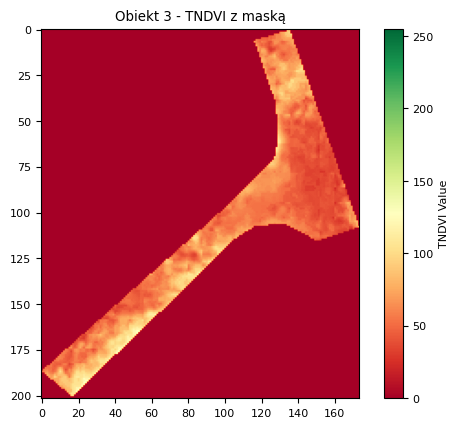

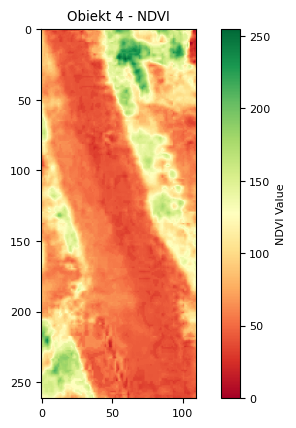

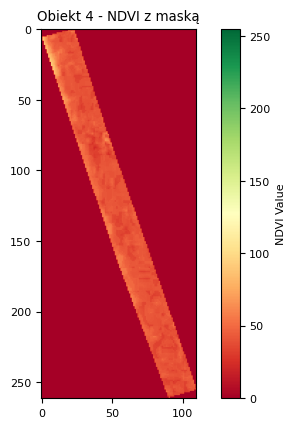

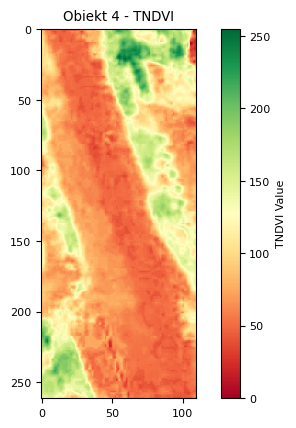

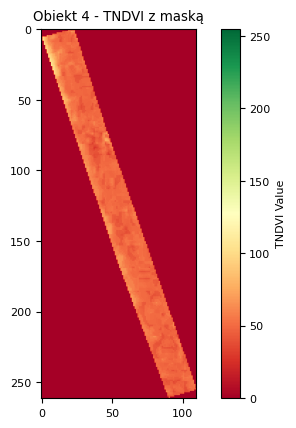

In [542]:
def calculate_NDVI(nir_array, red_array):
    IR = np.float32(nir_array)
    R = np.float32(red_array)
    NDVI = (IR-R)/(IR+R)
    NDVI[np.isnan(NDVI)] = 0
    return NDVI

#TNDVI - This index is useful for monitoring vegetation cover in urban environments. It does not saturate like NDVI
def calculate_TNDVI (nir_array, red_array):
    IR = np.float32(nir_array)
    R = np.float32(red_array)
    TDVI = np.sqrt(((IR-R)/(IR+R) + 0.5))
    TDVI[np.isnan(TDVI)] = 0
    return TDVI

NDVI_masked_list = []
TNDVI_masked_list = []

def normalize_raster(raster, vmin=None, vmax=None):
    if vmin is None or vmax is None:
        vmin, vmax = raster.min(), raster.max()
    raster_normalized = (raster - vmin) / (vmax - vmin)
    raster_0_255 = raster_normalized * 255
    return np.uint8(raster_0_255)
NDVI_statistics = []
TNDVI_statistics = []
for i in range (len(chosen_polygons)):

    fragmentNDVI = calculate_NDVI(nir_fragments[i], red_fragments[i])
    fragmentNDVI = normalize_raster(fragmentNDVI)
    # raster_normalized = (fragmentNDVI - fragmentNDVI.min())/(fragmentNDVI.max() -fragmentNDVI.min())
    # raster_0_255 = raster_normalized * 255
    # raster = np.uint8(raster_0_255)
    plt.imshow(fragmentNDVI, cmap='RdYlGn')
    cbar = plt.colorbar()
    cbar.set_label("NDVI Value")
    plt.title(f"Obiekt {i + 1} - NDVI")
    plt.savefig(f"object_{i + 1}_NDVI.png")
    plt.show()

    polygon_in_fragment_frame = shapely.affinity.translate(chosen_polygons[i], -bounds_list[i][0], -bounds_list[i][1])
    fragment_NDVI_masked, NDVI_no_data_mask = mask_fragment(fragmentNDVI, polygon_in_fragment_frame)
    fragmentNDVI_masked = normalize_raster(fragment_NDVI_masked,vmin=fragmentNDVI.min(), vmax=fragmentNDVI.max())
    plt.imshow(fragment_NDVI_masked, cmap='RdYlGn', vmin=fragmentNDVI.min(), vmax=fragmentNDVI.max())
    cbar = plt.colorbar()
    cbar.set_label("NDVI Value")
    plt.title(f"Obiekt {i + 1} - NDVI z maską")
    plt.show()

    NDVI_masked_list.append((fragment_NDVI_masked, NDVI_no_data_mask))

    fragmentTNDVI = calculate_TNDVI(nir_fragments[i], red_fragments[i])
    fragmentTNDVI = normalize_raster(fragmentTNDVI)
    plt.imshow(fragmentTNDVI, cmap='RdYlGn')
    cbar = plt.colorbar()
    cbar.set_label("TNDVI Value")
    plt.title(f"Obiekt {i + 1} - TNDVI")
    plt.savefig(f"object_{i + 1}_TNDVI.png")
    plt.show()

    fragmentTNDVI_masked, TNDVI_no_data_mask = mask_fragment(fragmentTNDVI, polygon_in_fragment_frame)
    fragmentTNDVI_masked = normalize_raster(fragmentTNDVI_masked,vmin=fragmentTNDVI.min(), vmax=fragmentTNDVI.max())

    plt.imshow(fragmentTNDVI_masked, cmap='RdYlGn', vmin=fragmentTNDVI.min(), vmax=fragmentTNDVI.max())
    cbar = plt.colorbar()
    cbar.set_label("TNDVI Value")
    plt.title(f"Obiekt {i + 1} - TNDVI z maską")
    plt.show()
    TNDVI_masked_list.append((fragmentTNDVI_masked, TNDVI_no_data_mask))

    NDVI_statistics.append(calc_statistics(fragmentNDVI))
    TNDVI_statistics.append(calc_statistics(fragmentTNDVI))

    

    


Zestawienie dla wskaźników spektralnych wartości statystycznych

[[  1.          42.          55.         103.         255.
   76.12259429]
 [  2.          50.          80.         137.         255.
   94.3265696 ]
 [  3.          53.         111.         157.         255.
  109.38540985]
 [  3.          45.          62.         104.         255.
   78.71449391]]
[[  1.          51.          67.         118.         255.
   87.70715545]
 [  2.          60.          94.         151.         255.
  105.98280449]
 [  3.          64.         125.         170.         255.
  120.63166131]
 [  4.          54.          74.         118.         255.
   89.76730629]]


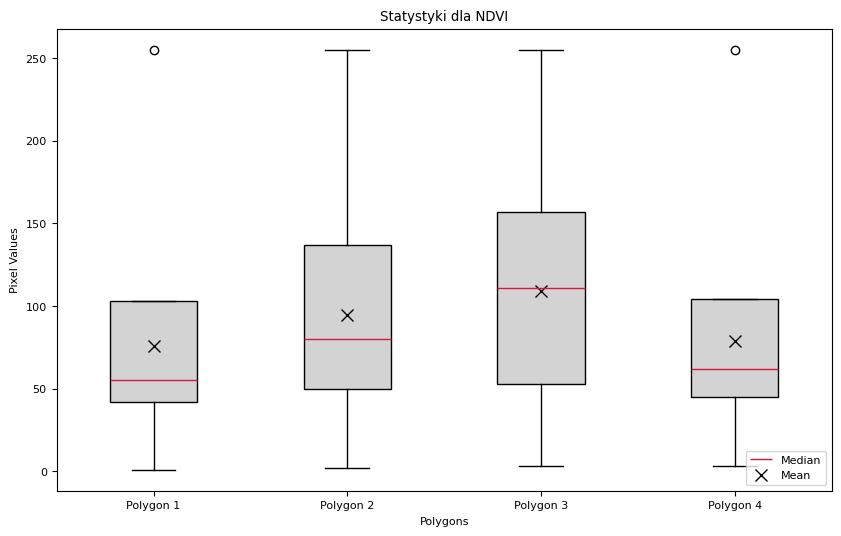

In [543]:
NDVI_statistics = np.array(NDVI_statistics)
print(NDVI_statistics)
TNDVI_statistics = np.array(TNDVI_statistics)
print(TNDVI_statistics)
plot_boxplot(NDVI_statistics, 'NDVI')
plt.title("Statystyki dla NDVI")
plt.show()

#calculate statistics for spectral indices
# NDVI_statistics = []
# TNDVI_statistics = []

# for i in range(len(chosen_polygons)):
#     NDVI_statistics.append(calc_statistics())
#     TNDVI_statistics.append(calc_statistics(TNDVI_masked_list[i][0], TNDVI_masked_list[i][1]))

# NDVI_statistics = np.array(NDVI_statistics)
# print(NDVI_statistics)
# TNDVI_statistics = np.array(TNDVI_statistics)

# plot_boxplot(NDVI_statistics, 'NDVI')
# plt.title("Statystyki dla NDVI 2015r")
# plt.show()
# print(TNDVI_statistics)
# plot_boxplot(TNDVI_statistics, 'TNDVI')
# plt.title("Statystyki dla TNDVI 2015r")
# plt.show()
